In [1]:
!pip install -q transformers torch numpy pandas scikit-learn

In [2]:
! wget https://huggingface.co/datasets/KELONMYOSA/dusha_emotion_audio/resolve/main/data/test.tar.gz --no-check-certificate

--2023-07-11 20:25:21--  https://huggingface.co/datasets/KELONMYOSA/dusha_emotion_audio/resolve/main/data/test.tar.gz
Resolving huggingface.co (huggingface.co)... 99.84.108.87, 99.84.108.129, 99.84.108.55, ...
Connecting to huggingface.co (huggingface.co)|99.84.108.87|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/f9/36/f936cc9a1834dea987df3d43bad12716beb9c022f2f51034d7372be499277925/c781fa6c20cafcda001dbf2b195ef60da536b8dba06e791286ff67345614d920?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27test.tar.gz%3B+filename%3D%22test.tar.gz%22%3B&response-content-type=application%2Fgzip&Expires=1689366322&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTY4OTM2NjMyMn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9mOS8zNi9mOTM2Y2M5YTE4MzRkZWE5ODdkZjNkNDNiYWQxMjcxNmJlYjljMDIyZjJmNTEwMzRkNzM3MmJlNDk5Mjc3OTI1L2M3ODFmYTZjMjBjYWZjZGEwMDFkYmYyYjE5NWVmNjB

In [ ]:
! tar -xvzf test.tar.gz

In [4]:
import datasets
import transformers
import pandas as pd
import sklearn
import torch
import numpy as np

In [5]:
label2emotion = {
    0: "neutral",
    1: "positive",
    2: "sad",
    3: "angry",
    4: "other"
}

In [6]:
dataset_dataframe = pd.read_csv('test.csv')
dataset_dataframe.columns = ['file', 'label']
dataset_dataframe['emotion'] = dataset_dataframe['label'].replace(label2emotion)
text_frame = pd.read_csv('test_with_text.csv')
text_frame.rename(columns={'audio_path':'file'}, inplace=True)
text_frame.drop(columns=['Unnamed: 0'], inplace=True)
dataset_dataframe = dataset_dataframe.merge(text_frame, how='left', on='file').drop(columns=['emotion'])
dataset_dataframe['predicted_text'].fillna(' ', inplace=True)

In [7]:
train_dataset_dataframe = pd.read_csv('train_dataset.csv')
train_text_frame = pd.read_csv('train_with_text.csv')

In [8]:
train_text_frame.rename(columns = {'audio_path':'file'}, inplace=True)
train_text_frame.drop(columns=['Unnamed: 0'], inplace=True)

In [9]:
train_dataset_dataframe.rename(columns = {'audio_path':'file'}, inplace=True)

In [10]:
train_frame = train_text_frame.merge(train_dataset_dataframe, how='left', on='file')

In [11]:
train_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158416 entries, 0 to 158415
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   file            158416 non-null  object
 1   predicted_text  158416 non-null  object
 2   label           158416 non-null  object
dtypes: object(3)
memory usage: 3.6+ MB


In [12]:
def accuracy(y_true, y_pred) -> float:
    return torch.sum(y_true == y_pred)

In [13]:
import torch
from transformers import AutoModelForSequenceClassification, BertForSequenceClassification
from transformers import BertTokenizerFast, AutoTokenizer
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
import torchaudio
import torch
from typing import List
from transformers import get_linear_schedule_with_warmup
import time
from torch.optim import AdamW
from transformers.optimization import Adafactor
import torch.nn as nn

In [47]:
classes = ['sad', 'neutral', 'angry', 'positive', 'other']

In [48]:
for class_ in classes:
    print(class_, len(dataset.loc[dataset['label'] == class_]))

sad 8000
neutral 8000
angry 8000
positive 8000
other 8554


In [44]:
datasets = []
for class_ in classes:
    datasets.append(train_frame.loc[train_frame['label'] == class_][:8000])
datasets += [train_frame.loc[train_frame['label'] == 'other']]*25

In [45]:
dataset = pd.concat(datasets)

In [46]:
len(dataset)

40554

In [49]:
def pad_tensor(vec, pad, dim):
    """
    args:
        vec - tensor to pad
        pad - the size to pad to
        dim - dimension to pad

    return:
        a new tensor padded to 'pad' in dimension 'dim'
    """
    pad_size = list(vec.shape)
    pad_size[dim] = pad - vec.size(dim)
    return torch.cat([vec, torch.zeros(*pad_size)], dim=dim)

class PadCollate:
    """
    a variant of callate_fn that pads according to the longest sequence in
    a batch of sequences
    """

    def __init__(self, dim=0):
        """
        args:
            dim - the dimension to be padded (dimension of time in sequences)
        """
        self.dim = dim

    def pad_collate(self, batch):
        """
        args:
            batch - list of (tensor, label)

        reutrn:
            xs - a tensor of all examples in 'batch' after padding
            ys - a LongTensor of all labels in batch
        """
        # find longest sequence
        max_len = max(map(lambda x: x[0].shape[self.dim], batch))
        # pad
        data = [pad_tensor(x[0], pad=max_len, dim=self.dim) for x in batch]
        # stack all
        xs = torch.stack(data, dim=0)
        ys = torch.LongTensor([y[1] for y in batch])
        return xs, ys

    def __call__(self, batch):
        return self.pad_collate(batch)

collator = PadCollate(dim=1)

In [50]:
tokenizer = AutoTokenizer.from_pretrained('Aniemore/rubert-tiny2-russian-emotion-detection')

In [51]:
class TestDataset(Dataset):
    def __init__(self, dataframe, train: bool = True, shuffle: bool = True):
        # self.n = 0.8
        self.data = dataframe
        
        # size = int(len(dataframe)*self.n)
        if shuffle:
            mask = torch.randperm(len(dataframe))
            self.data = self.data.iloc[mask]
        # if train:
        #     self.data = self.data[:size]
        # else:
        #     self.data = self.data[size:]

        self.emotion2label = {
            "neutral":0,
            "positive":1,
            "sad":2,
            "angry":3,
            "other":4
        }
        self.texts = self.data['predicted_text'].values
        self.labels = self.data['label'].values
        self.tokens = [self.tokenize_function(x) for x in self.texts]

    def tokenize_function(self, text):
        return tokenizer(text, max_length=512, padding='max_length', return_tensors='pt')

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):

        # print(self.tokenize_function(self.data['predicted_text'][idx]))
        # print(self.texts[idx])
        tokenized = self.tokens[idx]
        return torch.cat([tokenized['input_ids'], 
                          tokenized['token_type_ids'], 
                          tokenized['attention_mask']], 0), torch.tensor(self.emotion2label[self.labels[idx]])
            
        

In [52]:
train = TestDataset(dataset, shuffle=True)
test = TestDataset(dataset_dataframe, shuffle=True)

In [53]:
len(train)

40554

In [54]:
bs = 32
test_loader = DataLoader(
    test,
    batch_size = bs,
    collate_fn=collator
)
train_loader = DataLoader(
    train,
    batch_size = bs,
    collate_fn=collator
)

In [55]:
device = 'cuda'

In [56]:

model = BertForSequenceClassification.from_pretrained('Aniemore/rubert-tiny2-russian-emotion-detection', ignore_mismatched_sizes=True, return_dict=True, num_labels=5).to(device)
None

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Aniemore/rubert-tiny2-russian-emotion-detection and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([7, 312]) in the checkpoint and torch.Size([5, 312]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [76]:
import pickle

In [78]:
pickle.dump(dataset, open('dataset.pkl', 'wb'))

In [57]:
print(float(2e-5))

2e-05


In [58]:
# loss = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr = 5e-5)

In [59]:
epochs = 8
losses = []

In [60]:
model.train()
None

In [61]:
# for name, param in model.named_parameters():
#     if 'classifier' not in name: # classifier layer
#         param.requires_grad = False
#     else:
#         param.requires_grad = True


In [62]:
# b_input_ids, b_input_mask, b_type_ids,  b_labels = data[:, 0, :], data[:, 1, :], data[:, 2, :], labels

for epoch in range(epochs):
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        
        data, labels = batch
        b_input_ids, b_type_ids, b_input_mask,  = data[:, 0, :], data[:, 1, :], data[:, 2, :]
        one_hot_labels = nn.functional.one_hot(labels.cuda(), num_classes=5).float()
        output = model(b_input_ids.cuda().long(),
                       b_input_mask.cuda(),
                       b_type_ids.cuda().long(),
                       labels=one_hot_labels
                      )
        # print(output)
        loss_ = output[0]
        loss_.backward()
        losses.append(loss_.cpu())
        optimizer.step()

        

  0%|          | 0/1268 [00:00<?, ?it/s]

  0%|          | 0/1268 [00:00<?, ?it/s]

  0%|          | 0/1268 [00:00<?, ?it/s]

  0%|          | 0/1268 [00:00<?, ?it/s]

  0%|          | 0/1268 [00:00<?, ?it/s]

  0%|          | 0/1268 [00:00<?, ?it/s]

  0%|          | 0/1268 [00:00<?, ?it/s]

  0%|          | 0/1268 [00:00<?, ?it/s]

In [63]:
import matplotlib.pyplot as plt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


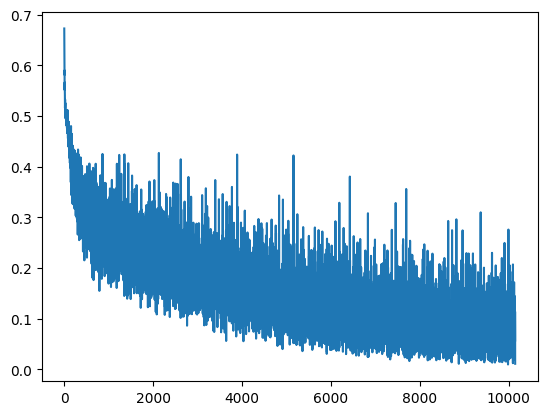

In [64]:
plt.plot(list(range(len(losses))), [x.detach().cpu() for x in losses])

In [65]:
correct = 0
print(len(test))
model = model.eval()
pred = []
test_arr = []
for batch in tqdm(test_loader):
    data, labels = batch
    b_input_ids, b_type_ids, b_input_mask  = data[:, 0, :], data[:, 1, :], data[:, 2, :]
    output = model(b_input_ids.long().cuda(),
                   b_input_mask.cuda(),
                   b_type_ids.long().cuda())
    # print(output[0][1].cpu())
    # print(torch.argmax(output[0], dim=1))
    correct += torch.sum(torch.argmax(output[0].cpu()) == labels)
    pred.append(torch.argmax(output[0], dim=1).detach().cpu())
    test_arr.append(labels.detach().cpu())

# print(correct/len(test))
        

24171


  0%|          | 0/756 [00:00<?, ?it/s]

In [66]:
from sklearn.metrics import classification_report
pred = torch.cat(pred, dim=0)
test_arr = torch.cat(test_arr, dim=0)
print(classification_report(test_arr, pred))

              precision    recall  f1-score   support

           0       0.83      0.54      0.66     15886
           1       0.44      0.70      0.54      2481
           2       0.19      0.32      0.23      2506
           3       0.38      0.45      0.41      3072
           4       0.09      0.82      0.16       226

    accuracy                           0.52     24171
   macro avg       0.39      0.56      0.40     24171
weighted avg       0.66      0.52      0.56     24171



In [67]:
!mkdir model

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [73]:
model.save_pretrained('./model/bert.ppt')

In [70]:
!cd model

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [74]:
!ls model

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
bert.ppt


In [40]:
model = model.eval()

In [28]:
import gc

gc.collect()

4520

In [19]:
model.train()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, 

In [296]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Tue Jul 11 13:10:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:02:00.0 Off |                  N/A |
|  0

In [80]:
with open('test_dataset.pkl', 'wb') as file:
    pickle.dump(dataset_dataframe, file)